In [11]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20}) #make plots more readable

import palettable as pal

import MagellanicStream as ms

import Calculate_Stellar_Field_Mass as fm #field mass
import field_area_calculation as fa #field area

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [12]:
##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    '''
    - data: some 1d array-like object that possibly has duplicate values
    Returns dictionary of duplicates and array of indices
    '''
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

def dist2LMC(ra, dec, alph0, delt0, pa, io):
    '''
    - ra: right ascension of stars
    - dec: declination of stars
    - alph0: right ascension of center of LMC
    - delt0: declination of center of LMC
    - pa: position angle of line of nodes
    - io: inclination of LMC disk
    Calculate distance to stars in LMC assuming an inclined disk in the sky
    '''
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis


def sal(MH,aM):
    '''
    Calculate the Salaris correction to the overall metallicity
    '''
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat):
    '''
    Calculate the median absolute deviation of 1d array-like object dat
    '''
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [13]:
###Code to Convert to MS coordinates
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

class MagellanicStream(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the Magellanic Stream
    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    MSLongitude : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to the Magellanic Stream.
    MSLatitude : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to the Magellanic Stream.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the Stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.
    """
    default_representation = coord.SphericalRepresentation
    #default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'MSLongitude'),
            coord.RepresentationMapping('lat', 'MSLatitude'),
            coord.RepresentationMapping('distance', 'distance')]#,
        #coord.SphericalCosLatDifferential: [
        #    coord.RepresentationMapping('d_lon_coslat', 'pm_lon_coslat'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #    coord.RepresentationMapping('d_distance', 'radial_velocity')],
        #coord.SphericalDifferential: [
        #    coord.RepresentationMapping('d_lon', 'pm_lon'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #   coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    #frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
    #    frame_specific_representation_info[coord.SphericalCosLatDifferential]
    #frame_specific_representation_info[coord.UnitSphericalDifferential] = \
    #    frame_specific_representation_info[coord.SphericalDifferential]


MS_PHI = (180 + 8.5 + 90) * u.degree # Euler angles (from Nidever 2010)
MS_THETA = (90 + 7.5) * u.degree
MS_PSI = -32.724214217871349 * u.degree  # anode parameter from gal2mag.pro

D = rotation_matrix(MS_PHI, "z")
C = rotation_matrix(MS_THETA, "x")
B = rotation_matrix(MS_PSI, "z")
A = np.diag([1., 1., 1.])
MS_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, MagellanicStream)
def galactic_to_MS():
    """ Compute the transformation matrix from Galactic spherical to
        Magellanic Stream coordinates.
    """
    return MS_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, MagellanicStream, coord.Galactic)
def MS_to_galactic():
    """ Compute the transformation matrix from Magellanic Stream coordinates to
        spherical Galactic.
    """
    return matrix_transpose(MS_MATRIX)

###Actual coordinate transform from previous cell
#c_icrs = SkyCoord(ra=tmp.ra.data*u.degree, dec=tmp.dec.data*u.degree)
#c_ms = c_icrs.transform_to(MagellanicStream)
#ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [14]:
#########################
### Import fits files ###
#########################

#isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers_r13-l33-58672.fits.gz',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#old dr16
olddr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembersdist_dr16beta.fits.gz',1)
clnrold = np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))

clnrolddr16 = olddr16[clnrold]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/LMC_DR16_all_PDF.fits.gz', 1)
clnpdfout = pdfout[ np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))]

#Read in Christian's Model
Chrismod = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/abparam16_delgau1.5_1525.txt')

In [15]:
#Transform gaia ra and dec to L and B
c_icrs = SkyCoord(ra=clndr16['RA']*u.degree, dec=clndr16['DEC']*u.degree)
c_ms = c_icrs.transform_to(MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0

In [16]:
#######################
### Pick out Fields ###
#######################

dor30 = np.where(clndr16['FIELD']=='30Dor')
lmc1 = np.where(clndr16['FIELD']=='LMC1')
lmc2 = np.where(clndr16['FIELD']=='LMC2')
lmc3 = np.where(clndr16['FIELD']=='LMC3')
lmc4 = np.where(clndr16['FIELD']=='LMC4')
lmc5 = np.where(clndr16['FIELD']=='LMC5')
lmc6 = np.where(clndr16['FIELD']=='LMC6')
lmc7 = np.where(clndr16['FIELD']=='LMC7')
lmc8 = np.where(clndr16['FIELD']=='LMC8')
lmc9 = np.where(clndr16['FIELD']=='LMC9')
lmc10 = np.where(clndr16['FIELD']=='LMC10')
lmc11 = np.where(clndr16['FIELD']=='LMC11')
lmc12 = np.where(clndr16['FIELD']=='LMC12')
lmc13 = np.where(clndr16['FIELD']=='LMC13')
lmc14 = np.where(clndr16['FIELD']=='LMC14')
lmc16 = np.where(clndr16['FIELD']=='LMC16')
lmc17 = np.where(clndr16['FIELD']=='LMC17')

In [17]:
def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [18]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
# factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMC(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist)-clndr16['AK_TARG']
parage = parsec_age(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])
parage = np.squeeze(parage)

In [19]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [20]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in tqdm_notebook(range(len(clndr16)),desc='Done?'):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

In [21]:
min(clndr16['SELECTFUNC'])

1.1764706

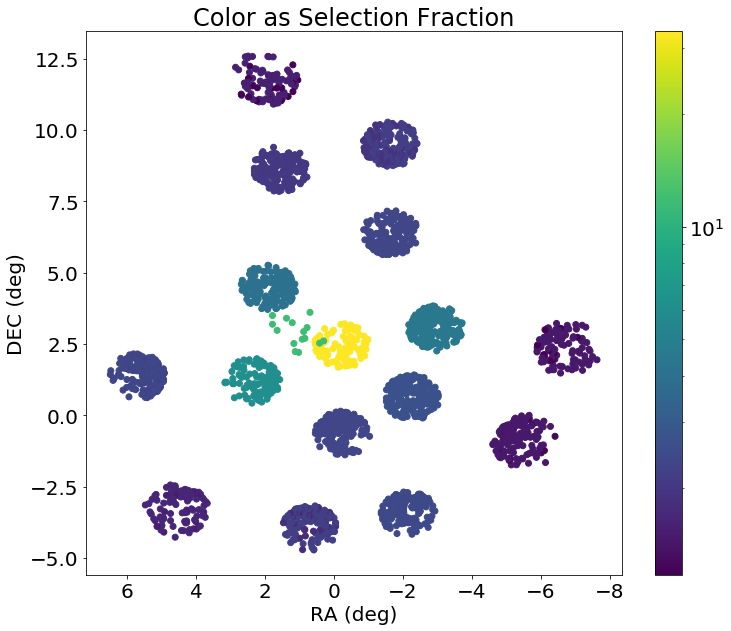

In [22]:
##########################
### Look at SELECTFUNC ###
##########################

'''SELECTFUNC is the ration of RGB to total stars observed'''

# #histogram
# plt.figure(figsize=[10,10])
# plt.hist(clndr16['SELECTFUNC'],density=True)
# plt.show()

plt.figure(figsize=[12,10])
plt.scatter(ms_lg-360,ms_bg,c=clndr16['SELECTFUNC'],norm=matplotlib.colors.LogNorm())
plt.gca().invert_xaxis()
plt.title(r'Color as Selection Fraction')
plt.colorbar()
plt.xlabel(r'RA (deg)')
plt.ylabel(r'DEC (deg)')
plt.savefig('selectionfunctionmap.pdf',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.hist(np.reciprocal(clndr16['SELECTFUNC']),density=True)
# plt.figure(figsize=[12,10])
# plt.show()

In [23]:
# f, ax = plt.subplots(6,3, facecolor='w',figsize=(15,12))
# ax[0,0].hist(clndr16['SELECTFUNC'][dor30],color='k',label='30Dor')
# ax[0,0].set_xlabel('SELECTFUNC')
# ax[0,0].legend(loc='upper left')
# ax[0,0].set_ylabel('Count')

# ax[0,1].hist(clndr16['SELECTFUNC'][lmc1],color='k',label='LMC1')
# ax[0,1].set_xlabel('SELECTFUNC')
# ax[0,1].legend(loc='upper left')
# ax[0,1].set_ylabel('Count')

# ax[0,2].hist(clndr16['SELECTFUNC'][lmc2],color='k',label='LMC2')
# ax[0,2].set_xlabel('SELECTFUNC')
# ax[0,2].legend(loc='upper left')
# ax[0,2].set_ylabel('Count')

# ax[1,0].hist(clndr16['SELECTFUNC'][lmc3],color='k',label='LMC3')
# ax[1,0].set_xlabel('SELECTFUNC')
# ax[1,0].legend(loc='upper left')
# ax[1,0].set_ylabel('Count')

# ax[1,1].hist(clndr16['SELECTFUNC'][lmc4],color='k',label='LMC4')
# ax[1,1].set_xlabel('SELECTFUNC')
# ax[1,1].legend(loc='upper left')
# ax[1,1].set_ylabel('Count')

# ax[1,2].hist(clndr16['SELECTFUNC'][lmc5],color='k',label='LMC5')
# ax[1,2].set_xlabel('SELECTFUNC')
# ax[1,2].legend(loc='upper left')
# ax[1,2].set_ylabel('Count')

# ax[2,0].hist(clndr16['SELECTFUNC'][lmc6],color='k',label='LMC6')
# ax[2,0].set_xlabel('SELECTFUNC')
# ax[2,0].legend(loc='upper left')
# ax[2,0].set_ylabel('Count')

# ax[2,1].hist(clndr16['SELECTFUNC'][lmc7],color='k',label='LMC7')
# ax[2,1].set_xlabel('SELECTFUNC')
# ax[2,1].legend(loc='upper left')
# ax[2,1].set_ylabel('Count')

# ax[2,2].hist(clndr16['SELECTFUNC'][lmc8],color='k',label='LMC8')
# ax[2,2].set_xlabel('SELECTFUNC')
# ax[2,2].legend(loc='upper left')
# ax[2,2].set_ylabel('Count')

# ax[3,0].hist(clndr16['SELECTFUNC'][lmc9],color='k',label='LMC9')
# ax[3,0].set_xlabel('SELECTFUNC')
# ax[3,0].legend(loc='upper left')
# ax[3,0].set_ylabel('Count')

# ax[3,1].hist(clndr16['SELECTFUNC'][lmc10],color='k',label='LMC10')
# ax[3,1].set_xlabel('SELECTFUNC')
# ax[3,1].legend(loc='upper left')
# ax[3,1].set_ylabel('Count')

# ax[3,2].hist(clndr16['SELECTFUNC'][lmc11],color='k',label='LMC11')
# ax[3,2].set_xlabel('SELECTFUNC')
# ax[3,2].legend(loc='upper left')
# ax[3,2].set_ylabel('Count')

# ax[4,0].hist(clndr16['SELECTFUNC'][lmc12],color='k',label='LMC12')
# ax[4,0].set_xlabel('SELECTFUNC')
# ax[4,0].legend(loc='upper left')
# ax[4,0].set_ylabel('Count')

# ax[4,1].hist(clndr16['SELECTFUNC'][lmc13],color='k',label='LMC13')
# ax[4,1].set_xlabel('SELECTFUNC')
# ax[4,1].legend(loc='upper left')
# ax[4,1].set_ylabel('Count')

# ax[4,2].hist(clndr16['SELECTFUNC'][lmc14],color='k',label='LMC14')
# ax[4,2].set_xlabel('SELECTFUNC')
# ax[4,2].legend(loc='upper left')
# ax[4,2].set_ylabel('Count')

# ax[5,0].hist(clndr16['SELECTFUNC'][lmc16],color='k',label='LMC16')
# ax[5,0].set_xlabel('SELECTFUNC')
# ax[5,0].legend(loc='upper left')
# ax[5,0].set_ylabel('Count')

# ax[5,1].hist(clndr16['SELECTFUNC'][lmc17],color='k',label='LMC17')
# ax[5,1].set_xlabel('SELECTFUNC')
# ax[5,1].legend(loc='upper left')
# ax[5,1].set_ylabel('Count')

# ax[5,2].hist(0,color='r',label='Field')
# ax[5,2].set_xlabel('SELECTFUNC')
# ax[5,2].legend(loc='upper left')
# ax[5,2].set_ylabel('Count')

# f.show()

In [24]:
# f, ax = plt.subplots(6,3, facecolor='w',figsize=(15,12))
# ax[0,0].scatter(clndr16['SELECTFUNC'][dor30],clndr16['TARGET_TYPE'][dor30],color='k',label='30Dor')
# ax[0,0].set_xlabel('SELECTFUNC')
# ax[0,0].legend(loc='upper left')
# ax[0,0].set_ylabel('TARGET_TYPE')

# ax[0,1].scatter(clndr16['SELECTFUNC'][lmc1],clndr16['TARGET_TYPE'][lmc1],color='k',label='LMC1')
# ax[0,1].set_xlabel('SELECTFUNC')
# ax[0,1].legend(loc='upper left')
# ax[0,1].set_ylabel('TARGET_TYPE')

# ax[0,2].scatter(clndr16['SELECTFUNC'][lmc2],clndr16['TARGET_TYPE'][lmc2],color='k',label='LMC2')
# ax[0,2].set_xlabel('SELECTFUNC')
# ax[0,2].legend(loc='upper left')
# ax[0,2].set_ylabel('TARGET_TYPE')

# ax[1,0].scatter(clndr16['SELECTFUNC'][lmc3],clndr16['TARGET_TYPE'][lmc3],color='k',label='LMC3')
# ax[1,0].set_xlabel('SELECTFUNC')
# ax[1,0].legend(loc='upper left')
# ax[1,0].set_ylabel('TARGET_TYPE')

# ax[1,1].scatter(clndr16['SELECTFUNC'][lmc4],clndr16['TARGET_TYPE'][lmc4],color='k',label='LMC4')
# ax[1,1].set_xlabel('SELECTFUNC')
# ax[1,1].legend(loc='upper left')
# ax[1,1].set_ylabel('TARGET_TYPE')

# ax[1,2].scatter(clndr16['SELECTFUNC'][lmc5],clndr16['TARGET_TYPE'][lmc5],color='k',label='LMC5')
# ax[1,2].set_xlabel('SELECTFUNC')
# ax[1,2].legend(loc='upper left')
# ax[1,2].set_ylabel('TARGET_TYPE')

# ax[2,0].scatter(clndr16['SELECTFUNC'][lmc6],clndr16['TARGET_TYPE'][lmc6],color='k',label='LMC6')
# ax[2,0].set_xlabel('SELECTFUNC')
# ax[2,0].legend(loc='upper left')
# ax[2,0].set_ylabel('TARGET_TYPE')

# ax[2,1].scatter(clndr16['SELECTFUNC'][lmc7],clndr16['TARGET_TYPE'][lmc7],color='k',label='LMC7')
# ax[2,1].set_xlabel('SELECTFUNC')
# ax[2,1].legend(loc='upper left')
# ax[2,1].set_ylabel('TARGET_TYPE')

# ax[2,2].scatter(clndr16['SELECTFUNC'][lmc8],clndr16['TARGET_TYPE'][lmc8],color='k',label='LMC8')
# ax[2,2].set_xlabel('SELECTFUNC')
# ax[2,2].legend(loc='upper left')
# ax[2,2].set_ylabel('TARGET_TYPE')

# ax[3,0].scatter(clndr16['SELECTFUNC'][lmc9],clndr16['TARGET_TYPE'][lmc9],color='k',label='LMC9')
# ax[3,0].set_xlabel('SELECTFUNC')
# ax[3,0].legend(loc='upper left')
# ax[3,0].set_ylabel('TARGET_TYPE')

# ax[3,1].scatter(clndr16['SELECTFUNC'][lmc10],clndr16['TARGET_TYPE'][lmc10],color='k',label='LMC10')
# ax[3,1].set_xlabel('SELECTFUNC')
# ax[3,1].legend(loc='upper left')
# ax[3,1].set_ylabel('TARGET_TYPE')

# ax[3,2].scatter(clndr16['SELECTFUNC'][lmc11],clndr16['TARGET_TYPE'][lmc11],color='k',label='LMC11')
# ax[3,2].set_xlabel('SELECTFUNC')
# ax[3,2].legend(loc='upper left')
# ax[3,2].set_ylabel('TARGET_TYPE')

# ax[4,0].scatter(clndr16['SELECTFUNC'][lmc12],clndr16['TARGET_TYPE'][lmc12],color='k',label='LMC12')
# ax[4,0].set_xlabel('SELECTFUNC')
# ax[4,0].legend(loc='upper left')
# ax[4,0].set_ylabel('TARGET_TYPE')

# ax[4,1].scatter(clndr16['SELECTFUNC'][lmc13],clndr16['TARGET_TYPE'][lmc13],color='k',label='LMC13')
# ax[4,1].set_xlabel('SELECTFUNC')
# ax[4,1].legend(loc='upper left')
# ax[4,1].set_ylabel('TARGET_TYPE')

# ax[4,2].scatter(clndr16['SELECTFUNC'][lmc14],clndr16['TARGET_TYPE'][lmc14],color='k',label='LMC14')
# ax[4,2].set_xlabel('SELECTFUNC')
# ax[4,2].legend(loc='upper left')
# ax[4,2].set_ylabel('TARGET_TYPE')

# ax[5,0].scatter(clndr16['SELECTFUNC'][lmc16],clndr16['TARGET_TYPE'][lmc16],color='k',label='LMC16')
# ax[5,0].set_xlabel('SELECTFUNC')
# ax[5,0].legend(loc='upper left')
# ax[5,0].set_ylabel('TARGET_TYPE')

# ax[5,1].scatter(clndr16['SELECTFUNC'][lmc17],clndr16['TARGET_TYPE'][lmc17],color='k',label='LMC17')
# ax[5,1].set_xlabel('SELECTFUNC')
# ax[5,1].legend(loc='upper left')
# ax[5,1].set_ylabel('TARGET_TYPE')

# ax[5,2].scatter(1.35,9.5,color='r',label='Field')
# ax[5,2].set_xlabel('SELECTFUNC')
# ax[5,2].legend(loc='upper left')
# ax[5,2].set_ylabel('TARGET_TYPE')

# f.show()

In [25]:
print(set(np.copy(clndr16['TARGET_NAME'])))
print(set(np.copy(clndr16['TARGET_TYPE'])))
print(clndr16['TARGET_NAME'][0])
print(clndr16['TARGET_TYPE'][0])

{'FntRGB', 'BrtRGB'}
{9, 10}
BrtRGB
9


In [26]:
##################
### HR Diagram ###
##################

###HR Diagram Colored by Field 
# plt.figure(figsize=[10,10])
# plt.scatter((clndr16['J']-clndr16['K'])[dor30],clndr16['H'][dor30])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc1],clndr16['H'][lmc1])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc2],clndr16['H'][lmc2])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc3],clndr16['H'][lmc3])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc4],clndr16['H'][lmc4])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc5],clndr16['H'][lmc5])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc6],clndr16['H'][lmc6])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc7],clndr16['H'][lmc7])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc8],clndr16['H'][lmc8])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc9],clndr16['H'][lmc9])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc10],clndr16['H'][lmc10])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc11],clndr16['H'][lmc11])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc12],clndr16['H'][lmc12])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc13],clndr16['H'][lmc13])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc14],clndr16['H'][lmc14])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc16],clndr16['H'][lmc16])
# plt.scatter((clndr16['J']-clndr16['K'])[lmc17],clndr16['H'][lmc17])
# plt.gca().invert_yaxis()
# plt.xlabel('J-K')
# plt.title(r'Color as Field')
# plt.ylabel('H')
# plt.show()


In [27]:
# #############################
# ### HR Diagram for fields ###
# #############################

# f, ax = plt.subplots(6,3, facecolor='w',figsize=(12,15))
# ax[0,0].scatter((clndr16['J']-clndr16['K'])[dor30],clndr16['H'][dor30],color='k',label='30Dor')
# # ax[0,0].set_xlabel('J-k')
# ax[0,0].legend(loc='upper left')
# ax[0,0].invert_yaxis()
# ax[0,0].set_ylabel('H')

# ax[0,1].scatter((clndr16['J']-clndr16['K'])[lmc1],clndr16['H'][lmc1],color='k',label='LMC1')
# # ax[0,1].set_xlabel('J-K')
# ax[0,1].legend(loc='upper left')
# ax[0,1].invert_yaxis()
# # ax[0,1].set_ylabel('H')

# ax[0,2].scatter((clndr16['J']-clndr16['K'])[lmc2],clndr16['H'][lmc2],color='k',label='LMC2')
# # ax[0,2].set_xlabel('J-k')
# ax[0,2].legend(loc='upper left')
# ax[0,2].invert_yaxis()
# # ax[0,2].set_ylabel('H')

# ax[1,0].scatter((clndr16['J']-clndr16['K'])[lmc3],clndr16['H'][lmc3],color='k',label='LMC3')
# # ax[1,0].set_xlabel('J-k')
# ax[1,0].legend(loc='upper left')
# ax[1,0].invert_yaxis()
# ax[1,0].set_ylabel('H')

# ax[1,1].scatter((clndr16['J']-clndr16['K'])[lmc4],clndr16['H'][lmc4],color='k',label='LMC4')
# # ax[1,1].set_xlabel('J-K')
# ax[1,1].legend(loc='upper left')
# ax[1,1].invert_yaxis()
# # ax[1,1].set_ylabel('H')

# ax[1,2].scatter((clndr16['J']-clndr16['K'])[lmc5],clndr16['H'][lmc5],color='k',label='LMC5')
# # ax[1,2].set_xlabel('J-K')
# ax[1,2].legend(loc='upper left')
# ax[1,2].invert_yaxis()
# # ax[1,2].set_ylabel('H')

# ax[2,0].scatter((clndr16['J']-clndr16['K'])[lmc6],clndr16['H'][lmc6],color='k',label='LMC6')
# # ax[2,0].set_xlabel('J-K')
# ax[2,0].legend(loc='upper left')
# ax[2,0].invert_yaxis()
# ax[2,0].set_ylabel('H')

# ax[2,1].scatter((clndr16['J']-clndr16['K'])[lmc7],clndr16['H'][lmc7],color='k',label='LMC7')
# # ax[2,1].set_xlabel('J-K')
# ax[2,1].legend(loc='upper left')
# ax[2,1].invert_yaxis()
# # ax[2,1].set_ylabel('H')

# ax[2,2].scatter((clndr16['J']-clndr16['K'])[lmc8],clndr16['H'][lmc8],color='k',label='LMC8')
# # ax[2,2].set_xlabel('J-K')
# ax[2,2].legend(loc='upper left')
# ax[2,2].invert_yaxis()
# # ax[2,2].set_ylabel('H')

# ax[3,0].scatter((clndr16['J']-clndr16['K'])[lmc9],clndr16['H'][lmc9],color='k',label='LMC9')
# # ax[3,0].set_xlabel('J-K')
# ax[3,0].legend(loc='upper left')
# ax[3,0].invert_yaxis()
# ax[3,0].set_ylabel('H')

# ax[3,1].scatter((clndr16['J']-clndr16['K'])[lmc10],clndr16['H'][lmc10],color='k',label='LMC10')
# # ax[3,1].set_xlabel('J-K')
# ax[3,1].legend(loc='upper left')
# ax[3,1].invert_yaxis()
# # ax[3,1].set_ylabel('H')

# ax[3,2].scatter((clndr16['J']-clndr16['K'])[lmc11],clndr16['H'][lmc11],color='k',label='LMC11')
# # ax[3,2].set_xlabel('J-K')
# ax[3,2].legend(loc='upper left')
# ax[3,2].invert_yaxis()
# # ax[3,2].set_ylabel('H')

# ax[4,0].scatter((clndr16['J']-clndr16['K'])[lmc12],clndr16['H'][lmc12],color='k',label='LMC12')
# # ax[4,0].set_xlabel('J-K')
# ax[4,0].legend(loc='upper left')
# ax[4,0].invert_yaxis()
# ax[4,0].set_ylabel('H')

# ax[4,1].scatter((clndr16['J']-clndr16['K'])[lmc13],clndr16['H'][lmc13],color='k',label='LMC13')
# # ax[4,1].set_xlabel('J-K')
# ax[4,1].legend(loc='upper left')
# ax[4,1].invert_yaxis()
# # ax[4,1].set_ylabel('H')

# ax[4,2].scatter((clndr16['J']-clndr16['K'])[lmc14],clndr16['H'][lmc14],color='k',label='LMC14')
# # ax[4,2].set_xlabel('J-K')
# ax[4,2].legend(loc='upper left')
# ax[4,2].invert_yaxis()
# # ax[4,2].set_ylabel('H')

# ax[5,0].scatter((clndr16['J']-clndr16['K'])[lmc16],clndr16['H'][lmc16],color='k',label='LMC16')
# ax[5,0].set_xlabel('J-K')
# ax[5,0].legend(loc='upper left')
# ax[5,0].invert_yaxis()
# ax[5,0].set_ylabel('H')

# ax[5,1].scatter((clndr16['J']-clndr16['K'])[lmc17],clndr16['H'][lmc17],color='k',label='LMC17')
# ax[5,1].set_xlabel('J-K')
# ax[5,1].legend(loc='upper left')
# ax[5,1].invert_yaxis()
# # ax[5,1].set_ylabel('H')

# ax[5,2].scatter(0.75,12,color='r',label='Field')
# ax[5,2].set_xlabel('J-K')
# ax[5,2].legend(loc='upper left')
# ax[5,2].invert_yaxis()
# # ax[5,2].set_ylabel('H')

# f.suptitle(r'Field by Field HR Diagrams')
# f.show()

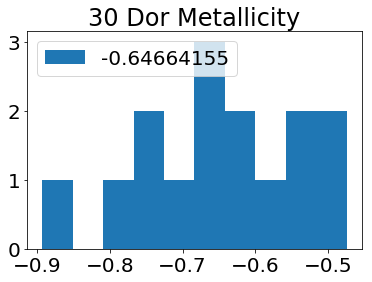

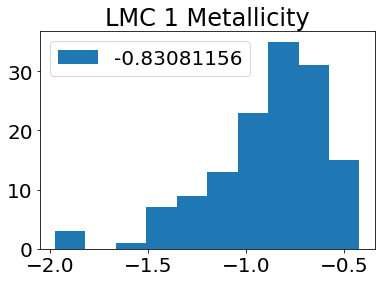

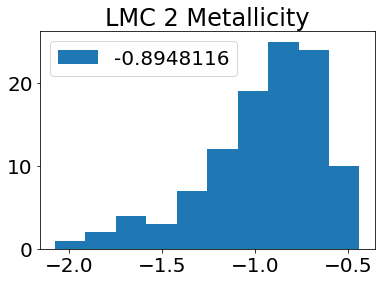

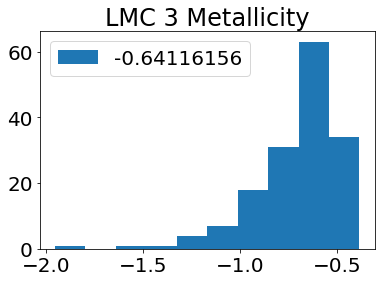

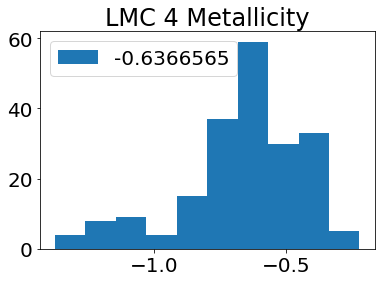

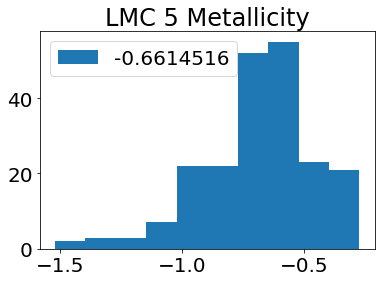

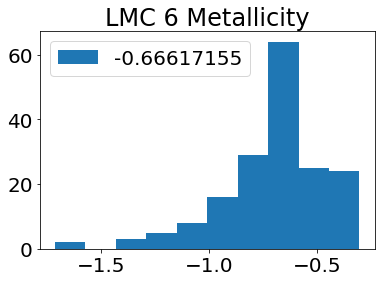

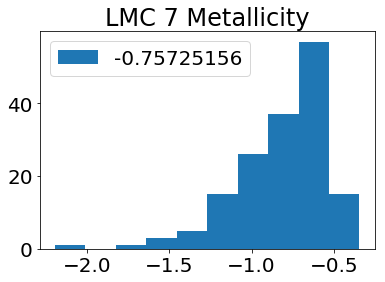

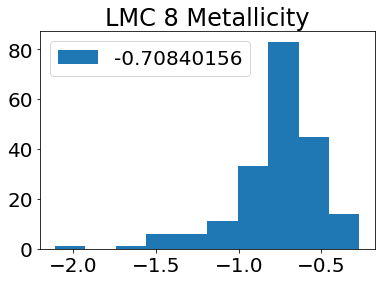

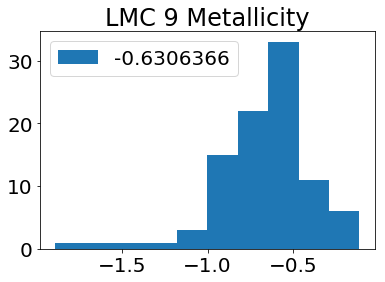

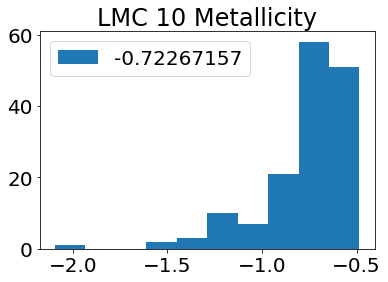

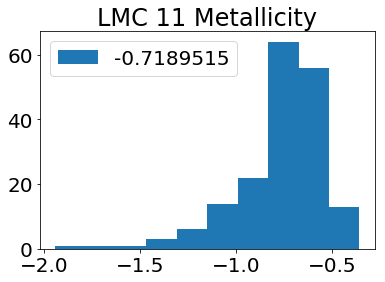

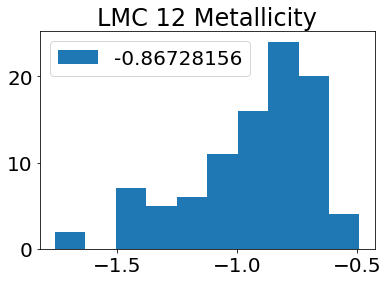

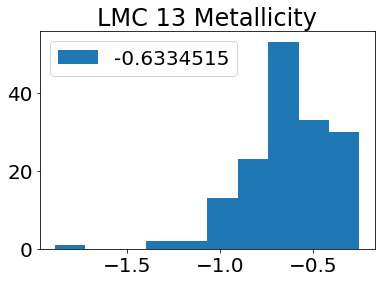

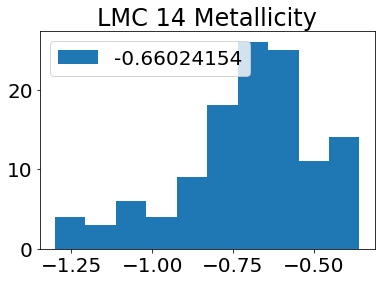

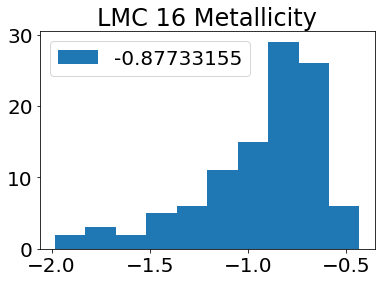

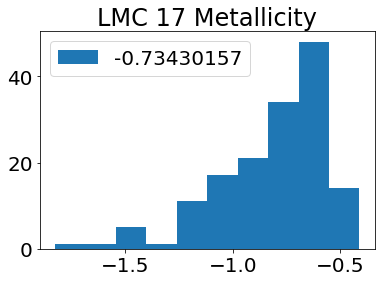

In [30]:
#30Dor
plt.hist(clndr16['FE_H'][dor30],label=str(np.median(clndr16['FE_H'][dor30])))
plt.legend(loc='upper left')
plt.title(r'30 Dor Metallicity')
plt.show()

#LMC1
plt.hist(clndr16['FE_H'][lmc1],label=str(np.median(clndr16['FE_H'][lmc1])))
plt.legend(loc='upper left')
plt.title(r'LMC 1 Metallicity')
plt.show()

#LMC2
plt.hist(clndr16['FE_H'][lmc2],label=str(np.median(clndr16['FE_H'][lmc2])))
plt.legend(loc='upper left')
plt.title(r'LMC 2 Metallicity')
plt.show()

#LMC3
plt.hist(clndr16['FE_H'][lmc3],label=str(np.median(clndr16['FE_H'][lmc3])))
plt.legend(loc='upper left')
plt.title(r'LMC 3 Metallicity')
plt.show()

#LMC4
plt.hist(clndr16['FE_H'][lmc4],label=str(np.median(clndr16['FE_H'][lmc4])))
plt.legend(loc='upper left')
plt.title(r'LMC 4 Metallicity')
plt.show()

#LMC5
plt.hist(clndr16['FE_H'][lmc5],label=str(np.median(clndr16['FE_H'][lmc5])))
plt.legend(loc='upper left')
plt.title(r'LMC 5 Metallicity')
plt.show()

#LMC5
plt.hist(clndr16['FE_H'][lmc6],label=str(np.median(clndr16['FE_H'][lmc6])))
plt.legend(loc='upper left')
plt.title(r'LMC 6 Metallicity')
plt.show()

#LMC7
plt.hist(clndr16['FE_H'][lmc7],label=str(np.median(clndr16['FE_H'][lmc7])))
plt.legend(loc='upper left')
plt.title(r'LMC 7 Metallicity')
plt.show()

#LMC8
plt.hist(clndr16['FE_H'][lmc8],label=str(np.median(clndr16['FE_H'][lmc8])))
plt.legend(loc='upper left')
plt.title(r'LMC 8 Metallicity')
plt.show()

#LMC9
plt.hist(clndr16['FE_H'][lmc9],label=str(np.median(clndr16['FE_H'][lmc9])))
plt.legend(loc='upper left')
plt.title(r'LMC 9 Metallicity')
plt.show()

#LMC10
plt.hist(clndr16['FE_H'][lmc10],label=str(np.median(clndr16['FE_H'][lmc10])))
plt.legend(loc='upper left')
plt.title(r'LMC 10 Metallicity')
plt.show()

#LMC11
plt.hist(clndr16['FE_H'][lmc11],label=str(np.median(clndr16['FE_H'][lmc11])))
plt.legend(loc='upper left')
plt.title(r'LMC 11 Metallicity')
plt.show()

#LMC12
plt.hist(clndr16['FE_H'][lmc12],label=str(np.median(clndr16['FE_H'][lmc12])))
plt.legend(loc='upper left')
plt.title(r'LMC 12 Metallicity')
plt.show()

#LMC13
plt.hist(clndr16['FE_H'][lmc13],label=str(np.median(clndr16['FE_H'][lmc13])))
plt.legend(loc='upper left')
plt.title(r'LMC 13 Metallicity')
plt.show()

#LMC14
plt.hist(clndr16['FE_H'][lmc14],label=str(np.median(clndr16['FE_H'][lmc14])))
plt.legend(loc='upper left')
plt.title(r'LMC 14 Metallicity')
plt.show()

#LMC16
plt.hist(clndr16['FE_H'][lmc16],label=str(np.median(clndr16['FE_H'][lmc16])))
plt.legend(loc='upper left')
plt.title(r'LMC 16 Metallicity')
plt.show()

#LMC17
plt.hist(clndr16['FE_H'][lmc17],label=str(np.median(clndr16['FE_H'][lmc17])))
plt.legend(loc='upper left')
plt.title(r'LMC 17 Metallicity')
plt.show()

In [29]:
#############################################
### Mass of Fields with only Bright stars ###
#############################################

import Calculate_Stellar_Field_Mass as fm #field mass

corabsH = absmag(clndr16['H'],stardist)-clndr16['AK_TARG']

'(age, met, maxAbs, minAbs, select, len(field))'

#30 Dor
mass30dor=fm.apogee_field_mass(8.7,-0.65,max(corabsH[dor30]),min(corabsH[dor30]),clndr16[dor30]['SELECTFUNC'][0],
                    len(np.squeeze(dor30)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 4
masslmc4=fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc4]),min(corabsH[lmc4]),clndr16[lmc4]['SELECTFUNC'][0],
                    len(np.squeeze(lmc4)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 5
masslmc5=fm.apogee_field_mass(8.7,-0.66,max(corabsH[lmc5]),min(corabsH[lmc5]),clndr16[lmc5]['SELECTFUNC'][0],
                    len(np.squeeze(lmc5)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 6
masslmc6=fm.apogee_field_mass(8.7,-0.67,max(corabsH[lmc6]),min(corabsH[lmc6]),clndr16[lmc6]['SELECTFUNC'][0],
                    len(np.squeeze(lmc6)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 8
masslmc8=fm.apogee_field_mass(8.7,-0.63,max(corabsH[lmc8]),min(corabsH[lmc8]),clndr16[lmc8]['SELECTFUNC'][0],
                    len(np.squeeze(lmc8)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 9
masslmc9=fm.apogee_field_mass(8.7,-0.63,max(corabsH[lmc9]),min(corabsH[lmc9]),clndr16[lmc9]['SELECTFUNC'][0],
                    len(np.squeeze(lmc9)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 13
masslmc13=fm.apogee_field_mass(8.7,-0.63,max(corabsH[lmc13]),min(corabsH[lmc13]),clndr16[lmc13]['SELECTFUNC'][0],
                    len(np.squeeze(lmc13)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 14
masslmc14=fm.apogee_field_mass(8.7,-0.66,max(corabsH[lmc14]),min(corabsH[lmc14]),clndr16[lmc14]['SELECTFUNC'][0],
                    len(np.squeeze(lmc14)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')

In [23]:
# import Calculate_Stellar_Field_Mass as fm #field mass
# masslmc4=fm.apogee_field_mass(8.7,-0.64,max(corabsH[dor30]),
#                               min(corabsH[dor30]),clndr16[dor30]['SELECTFUNC'][0],
#                               len(np.squeeze(dor30)),
#                               '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')




In [24]:
# print(dor30)
# print(corabsH[dor30])
print('Max H ',max(corabsH[dor30]))
print('Min H ',min(corabsH[dor30]))
print(clndr16[dor30]['SELECTFUNC'][0])

Max H  -6.047958238453429
Min H  -6.341338874636026
11.557693


In [25]:
# fnt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='FntRGB')
# brt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='BrtRGB')

# fntlmc1 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc1][fnt1]),min(corabsH[lmc1][fnt1]),
#                              clndr16[lmc1][fnt1]['SELECTFUNC'][0],len(np.squeeze(fnt1)),
#                              '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
# brtlmc1 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc1][brt1]),min(corabsH[lmc1][brt1]),
#                              clndr16[lmc1][brt1]['SELECTFUNC'][0],len(np.squeeze(brt1)),
#                              '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
# masslmc1 = fntlmc1+brtlmc1

In [26]:
# from scipy.interpolate import interp1d
# parsec_path = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat'
# age = 8.7
# metallicity = -0.64

# maxabsH = max(corabsH[dor30])
# minabsH = min(corabsH[dor30])
# selectfunc = clndr16[dor30]['SELECTFUNC'][0]
# number = len(np.squeeze(dor30))

# ###Load in isochrones from PARSEC
# parsecall = ascii.read(parsec_path, format='basic', delimiter='\s')
# rgb = np.where(parsecall['label']==3)
# parsec = parsecall[rgb]

# #find closest PARSEC isochrone z fraction
# parsec_mets = np.unique(np.asarray((np.log10(parsec['Zini']/0.02))))
# met_index = np.abs(parsec_mets-metallicity*np.ones(len(parsec_mets))).argmin()
# z_iso = 0.02*(10**parsec_mets[met_index])

# #find closest PARSEC isochrone age
# age = np.log10(age*(10**9))
# parsec_ages = np.unique(np.asarray(parsec['logAge']))
    
# age_index = np.abs(parsec_ages-age*np.ones(len(parsec_ages))).argmin()
# age_iso = parsec_ages[age_index]

# ###interpolate and find mass from int_IMF
# single_iso = np.where((parsec['Zini']==z_iso)&(parsec['logAge']==age_iso))

# # upto = np.where(parsec[single_iso]['Hmag']>=min(parsec[single_iso]['Hmag']))
# new_parsec = parsec[single_iso]#[0:int(np.squeeze(upto))]

# inter_iso = interp1d(new_parsec['Hmag'][::-1],new_parsec['int_IMF'][::-1],kind='cubic',
#                      bounds_error=False,fill_value='extrapolate',assume_sorted=False)

# diff_IMF = np.abs(inter_iso(maxabsH)-inter_iso(minabsH))

# print((selectfunc*number)/diff_IMF)

# print(new_parsec['Hmag'])


In [27]:
# print(len(np.squeeze(single_iso)))

In [28]:
# print(new_parsec['Hmag'][::-1])
# print(new_parsec['int_IMF'][::-1])

# print(single_iso)

In [29]:
########################################################
### Mass of Fields with composite Bright/Faint stars ###
########################################################

fnt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='FntRGB')
fnt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='FntRGB')
fnt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='FntRGB')
fnt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='FntRGB')
fnt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='FntRGB')
fnt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='FntRGB')
fnt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='FntRGB')
fnt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='FntRGB')
fnt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='FntRGB')

brt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='BrtRGB')
brt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='BrtRGB')
brt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='BrtRGB')
brt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='BrtRGB')
brt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='BrtRGB')
brt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='BrtRGB')
brt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='BrtRGB')
brt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='BrtRGB')
brt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='BrtRGB')

#LMC 1
fntlmc1 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc1][fnt1]),min(corabsH[lmc1][fnt1]),
                             clndr16[lmc1][fnt1]['SELECTFUNC'][0],len(np.squeeze(fnt1)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc1 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc1][brt1]),min(corabsH[lmc1][brt1]),
                             clndr16[lmc1][brt1]['SELECTFUNC'][0],len(np.squeeze(brt1)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc1 = fntlmc1+brtlmc1

#LMC 2
fntlmc2 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc2][fnt2]),min(corabsH[lmc2][fnt2]),
                             clndr16[lmc2][fnt2]['SELECTFUNC'][0],len(np.squeeze(fnt2)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc2 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc2][brt2]),min(corabsH[lmc2][brt2]),
                             clndr16[lmc2][brt2]['SELECTFUNC'][0],len(np.squeeze(brt2)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc2 = fntlmc2+brtlmc2

#LMC 3
fntlmc3 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc3][fnt3]),min(corabsH[lmc3][fnt3]),
                             clndr16[lmc3][fnt3]['SELECTFUNC'][0],len(np.squeeze(fnt3)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc3 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc3][brt3]),min(corabsH[lmc3][brt3]),
                             clndr16[lmc3][brt3]['SELECTFUNC'][0],len(np.squeeze(brt3)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc3 = fntlmc3+brtlmc3

#LMC 7
fntlmc7 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc7][fnt7]),min(corabsH[lmc7][fnt7]),
                             clndr16[lmc7][fnt7]['SELECTFUNC'][0],len(np.squeeze(fnt7)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc7 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc7][brt7]),min(corabsH[lmc7][brt7]),
                             clndr16[lmc7][brt7]['SELECTFUNC'][0],len(np.squeeze(brt7)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc7 = fntlmc7+brtlmc7

#LMC 10
fntlmc10 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc10][fnt10]),min(corabsH[lmc10][fnt10]),
                             clndr16[lmc10][fnt10]['SELECTFUNC'][0],len(np.squeeze(fnt10)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc10 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc10][brt10]),min(corabsH[lmc10][brt10]),
                             clndr16[lmc10][brt10]['SELECTFUNC'][0],len(np.squeeze(brt10)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc10 = fntlmc10+brtlmc10

#LMC 11
fntlmc11 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc11][fnt11]),min(corabsH[lmc11][fnt11]),
                             clndr16[lmc11][fnt11]['SELECTFUNC'][0],len(np.squeeze(fnt11)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc11 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc11][brt11]),min(corabsH[lmc11][brt11]),
                             clndr16[lmc11][brt11]['SELECTFUNC'][0],len(np.squeeze(brt11)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc11 = fntlmc11+brtlmc11

#LMC 12
fntlmc12 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc12][fnt12]),min(corabsH[lmc12][fnt12]),
                             clndr16[lmc12][fnt12]['SELECTFUNC'][0],len(np.squeeze(fnt12)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc12 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc12][brt12]),min(corabsH[lmc12][brt12]),
                             clndr16[lmc12][brt12]['SELECTFUNC'][0],len(np.squeeze(brt12)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc12 = fntlmc12+brtlmc12

#LMC 16
fntlmc16 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc16][fnt16]),min(corabsH[lmc16][fnt16]),
                             clndr16[lmc16][fnt16]['SELECTFUNC'][0],len(np.squeeze(fnt16)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc16 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc16][brt16]),min(corabsH[lmc16][brt16]),
                             clndr16[lmc16][brt16]['SELECTFUNC'][0],len(np.squeeze(brt16)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc16 = fntlmc16+brtlmc16

#LMC 17
fntlmc17 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc17][fnt17]),min(corabsH[lmc17][fnt17]),
                             clndr16[lmc17][fnt17]['SELECTFUNC'][0],len(np.squeeze(fnt17)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc17 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc17][brt17]),min(corabsH[lmc17][brt17]),
                             clndr16[lmc17][brt17]['SELECTFUNC'][0],len(np.squeeze(brt17)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc17 = fntlmc17+brtlmc17

In [30]:
#######################################
### All Field Masses and Total Mass ###
#######################################

print('30 Dor: '+str(mass30dor)+' Msol')
print('LMC 1: '+str(masslmc1)+' Msol')
print('LMC 2: '+str(masslmc2)+' Msol')
print('LMC 3: '+str(masslmc3)+' Msol')
print('LMC 4: '+str(masslmc4)+' Msol')
print('LMC 5: '+str(masslmc5)+' Msol')
print('LMC 6: '+str(masslmc6)+' Msol')
print('LMC 7: '+str(masslmc7)+' Msol')
print('LMC 8: '+str(masslmc8)+' Msol')
print('LMC 9: '+str(masslmc9)+' Msol')
print('LMC 10: '+str(masslmc10)+' Msol')
print('LMC 11: '+str(masslmc11)+' Msol')
print('LMC 12: '+str(masslmc12)+' Msol')
print('LMC 13: '+str(masslmc13)+' Msol')
print('LMC 14: '+str(masslmc14)+' Msol')
print('LMC 16: '+str(masslmc16)+' Msol')
print('LMC 17: '+str(masslmc17)+' Msol')
print('LMC RGB total: '+str((mass30dor+masslmc1+masslmc3+masslmc4+masslmc5+masslmc6+masslmc7+masslmc8+masslmc9+
                      masslmc10+masslmc11+masslmc12+masslmc13+masslmc14+masslmc16+masslmc17)/(10**9))+' GMsol')


30 Dor: 32927464.57371066 Msol
LMC 1: 5572483.623733364 Msol
LMC 2: 6679977.070952974 Msol
LMC 3: 25709185.82490531 Msol
LMC 4: 64771374.75346008 Msol
LMC 5: 64805836.978517845 Msol
LMC 6: 46592037.053218625 Msol
LMC 7: 29099287.888635986 Msol
LMC 8: 56486740.48967899 Msol
LMC 9: 310135482.28607327 Msol
LMC 10: 18618878.908226006 Msol
LMC 11: 63059176.76095544 Msol
LMC 12: 4598063.85076002 Msol
LMC 13: 66558571.664850526 Msol
LMC 14: 79684305.0148705 Msol
LMC 16: 5422922.860051526 Msol
LMC 17: 28531123.656959698 Msol
LMC RGB total: 0.9025729361886077 GMsol


In [31]:
mass = [mass30dor,masslmc1,masslmc3,masslmc4,masslmc5,masslmc6,masslmc7,masslmc8,masslmc9,
                      masslmc10,masslmc11,masslmc12,masslmc13,masslmc14,masslmc16,masslmc17]
max(mass)

dor30 = np.where(clndr16['FIELD']=='30Dor')
lmc1 = np.where(clndr16['FIELD']=='LMC1')
lmc2 = np.where(clndr16['FIELD']=='LMC2')
lmc3 = np.where(clndr16['FIELD']=='LMC3')
lmc4 = np.where(clndr16['FIELD']=='LMC4')
lmc5 = np.where(clndr16['FIELD']=='LMC5')
lmc6 = np.where(clndr16['FIELD']=='LMC6')
lmc7 = np.where(clndr16['FIELD']=='LMC7')
lmc8 = np.where(clndr16['FIELD']=='LMC8')
lmc9 = np.where(clndr16['FIELD']=='LMC9')
lmc10 = np.where(clndr16['FIELD']=='LMC10')
lmc11 = np.where(clndr16['FIELD']=='LMC11')
lmc12 = np.where(clndr16['FIELD']=='LMC12')
lmc13 = np.where(clndr16['FIELD']=='LMC13')
lmc14 = np.where(clndr16['FIELD']=='LMC14')
lmc16 = np.where(clndr16['FIELD']=='LMC16')
lmc17 = np.where(clndr16['FIELD']=='LMC17')

masses = []
for i in range(len(clndr16)):
    if clndr16['FIELD'][i] == '30Dor':
        masses.append(mass30dor)
    if clndr16['FIELD'][i] == 'LMC1':
        masses.append(masslmc1)
    if clndr16['FIELD'][i] == 'LMC2':
        masses.append(masslmc2)
    if clndr16['FIELD'][i] == 'LMC3':
        masses.append(masslmc3)
    if clndr16['FIELD'][i] == 'LMC4':
        masses.append(masslmc4)
    if clndr16['FIELD'][i] == 'LMC5':
        masses.append(masslmc5)
    if clndr16['FIELD'][i] == 'LMC6':
        masses.append(masslmc6)
    if clndr16['FIELD'][i] == 'LMC7':
        masses.append(masslmc7)
    if clndr16['FIELD'][i] == 'LMC8':
        masses.append(masslmc8)
    if clndr16['FIELD'][i] == 'LMC9':
        masses.append(masslmc9)
    if clndr16['FIELD'][i] == 'LMC10':
        masses.append(masslmc10)
    if clndr16['FIELD'][i] == 'LMC11':
        masses.append(masslmc11)
    if clndr16['FIELD'][i] == 'LMC12':
        masses.append(masslmc12)
    if clndr16['FIELD'][i] == 'LMC13':
        masses.append(masslmc13)
    if clndr16['FIELD'][i] == 'LMC14':
        masses.append(masslmc14)
    if clndr16['FIELD'][i] == 'LMC15':
        masses.append(masslmc15)
    if clndr16['FIELD'][i] == 'LMC16':
        masses.append(masslmc16)
    if clndr16['FIELD'][i] == 'LMC17':
        masses.append(masslmc17)
print(len(masses))
print(len(clndr16))

2427
2427


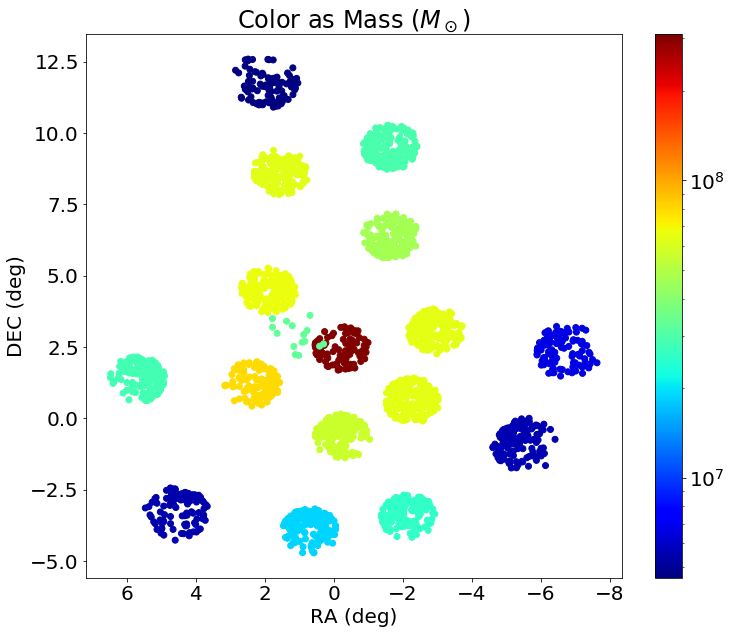

In [33]:


plt.figure(figsize=[12,10])
plt.scatter(ms_lg-360,ms_bg,c=masses,cmap='jet',norm=matplotlib.colors.LogNorm())
plt.gca().invert_xaxis()
plt.title(r'Color as Mass ($M_\odot$)')
plt.colorbar()
plt.xlabel(r'RA (deg)')
plt.ylabel(r'DEC (deg)')
plt.savefig('massmap.pdf',bbox_inches='tight')
plt.show()

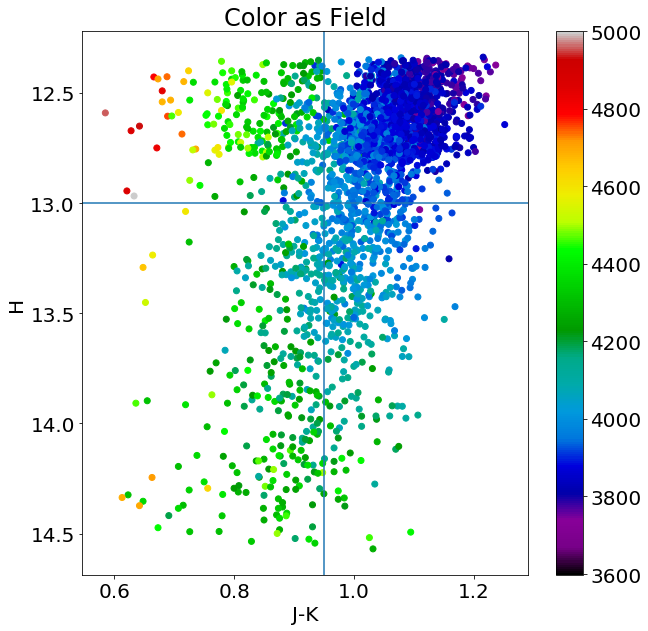

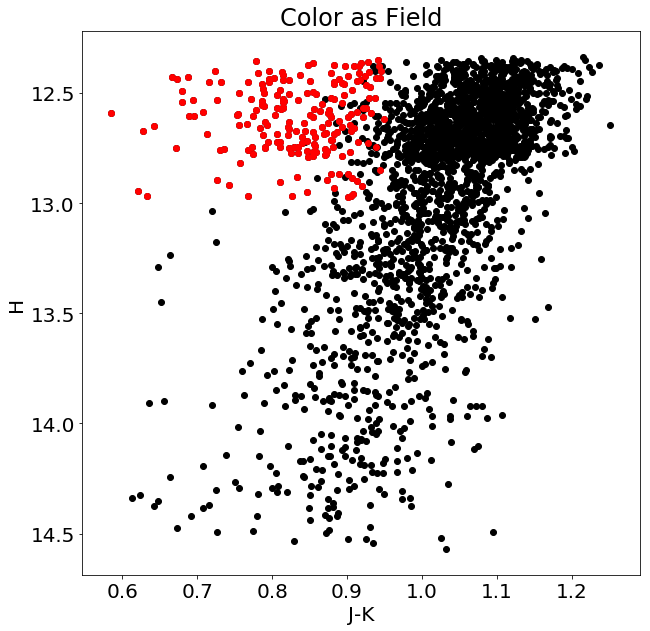

In [34]:
############################
### Find Blue Loop Stars ###
############################

###HR Diagram to find blue loop stars
plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],c=clndr16['TEFF'],cmap='nipy_spectral')
plt.axhline(13)
plt.axvline(0.95)
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Color as Field')
plt.ylabel('H')
plt.colorbar()
plt.show()

###Remove blue loop stars in data
bloop = np.where((clndr16['TEFF']>=4100)&(clndr16['H']<=13.0)&((clndr16['J']-clndr16['K'])<=0.95))

plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],color='k')
plt.scatter((clndr16['J']-clndr16['K'])[bloop],clndr16['H'][bloop],color='r')
# plt.axhline(13)
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Color as Field')
plt.ylabel('H')
plt.show()

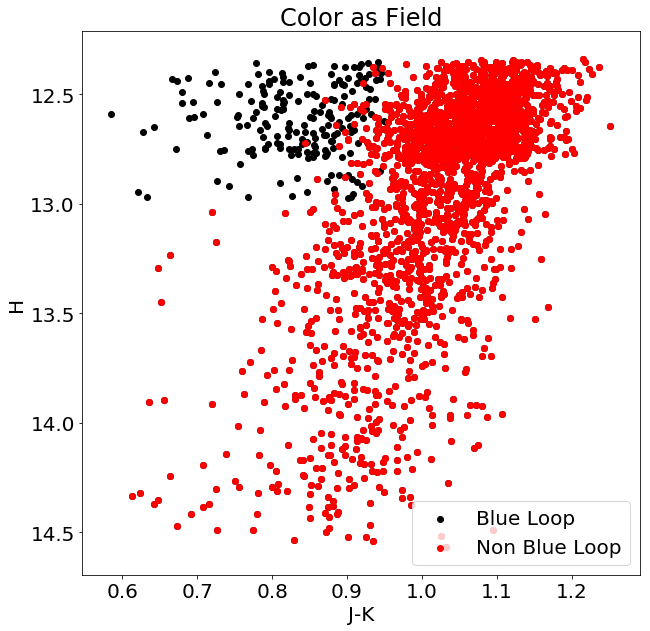

In [35]:
bloop_cut = []
for i in range(len(clndr16)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)

r13bloop_cut = clndr16[bloop_cut]
# print(np.squeeze(bloop).tolist())
# print(bloop_cut)

plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],color='k',label='Blue Loop')
plt.scatter((r13bloop_cut['J']-r13bloop_cut['K']),r13bloop_cut['H'],color='r',label='Non Blue Loop')
# plt.axhline(13)
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Color as Field')
plt.ylabel('H')
plt.legend()
plt.show()

In [44]:
######################################
### Get Cartesian Coordinates (MC) ### 
######################################

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

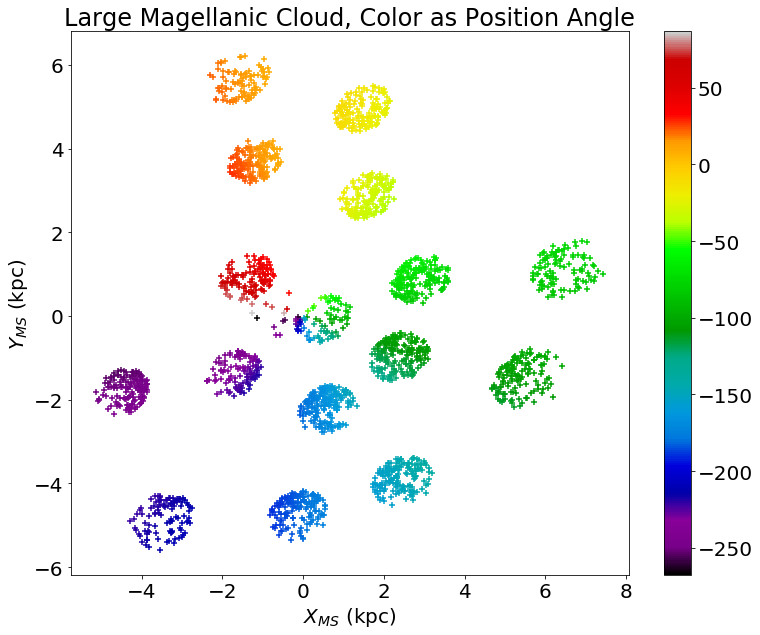

In [45]:
#####################################
### Plot in Cartesian Coordinates ###
#####################################

'''Double check units'''

#No Blue Loop Stars

x_m, y_m, dis = LMCdisk_cart(clndr16['RA'][bloop_cut],clndr16['DEC'][bloop_cut])
color = np.degrees(np.arctan2(y_m,x_m)-(np.pi/2)*np.ones(len(np.arctan2(y_m,x_m))))
# for i in range(len(color)):
#     if color[i]<0:
#         color[i] = color[i]+360

plt.figure(figsize=[12.5,10])
plt.scatter(x_m,y_m, marker='+',c=color,cmap='nipy_spectral')
plt.xlabel(r'$X_{MS}$ (kpc)')
plt.ylabel(r'$Y_{MS}$ (kpc)')
plt.title(r'Large Magellanic Cloud, Color as Position Angle')
plt.colorbar()
plt.savefig('LMCxy.jpg',bbox_inches='tight')
plt.show()

In [46]:
min(color)

-267.51524726483814

In [47]:
blmc1 = np.where(r13bloop_cut['Field']=='LMC1')
positions = []
for i in range(len(np.squeeze(blmc1))):
    positions.append([x_m[blmc1][i],y_m[blmc1][i]])
    
centroid = np.asarray(positions).mean(axis=0)
print(centroid)

[ 5.35129316 -1.44055125]


In [48]:
print(r13bloop_cut['Field'])

['LMC9' 'LMC9' 'LMC9' ... 'LMC12' 'LMC12' 'LMC12']


In [49]:
print('DEC: ',np.absolute(max(clndr16['DEC'])-min(clndr16['DEC']))*0.875)
print('YMS:',np.absolute(max(y_m)-min(y_m)))


DEC:  15.16886175
YMS: 11.797527775408092


In [50]:
(15.16886175-11.739298904661641)

3.429562845338358

In [51]:
# def testLMCdisk_cart(ra, dec, pa, io):
    
#     '''
#     Calculate the position of stars in the LMC disk plane with 
#     center at the LMC center in cartesian coordinates (x, y).
#     This also calculates the distance to the individual stars.
    
#     This follows van der Marel and Cioni 2001 
    
#     Input
#     - ra: right ascension of stars
#     - dec: declination of stars
    
#     Output
#     - x_m: x coordinate
#     - y_m: y coordinate
#     - dis: distance to LMC star
#     '''
#     alph0 = np.radians(82.25) #right ascension of center of LMC
#     delt0 = np.radians(-69.50) #declination of center of LMC
#     pa = np.radians(pa+90.00) #np.radians(149.23+90.00) #146.37 #position angle of line of nodes
#     io = np.radians(io) #np.radians(25.86) #27.81 #inclination of LMC disk
#     d0 = 49.90 #distance to center of LMC
    
#     #convert to radians
#     ra = np.radians(ra)
#     dec = np.radians(dec)
#     sd = np.sin(delt0)
#     cd = np.cos(delt0)
    
#     cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
#     srcp = -np.cos(dec)*np.sin(ra-alph0)
#     srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
#     dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
#     x_m = dis*srcp
#     y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
#     return x_m, y_m, dis

In [52]:
# x11,x12,x13 = testLMCdisk_cart(clndr16['RA'][bloop_cut],clndr16['DEC'][bloop_cut], 149.23, 25.86)
# # x21,x22,x23 = testLMCdisk_cart(clndr16['RA'][bloop_cut],clndr16['DEC'][bloop_cut], 121.90, 36.50)
# x21,x22,x23 = testLMCdisk_cart(clndr16['RA'][bloop_cut],clndr16['DEC'][bloop_cut], 146.90, 27.81) #146.90
# plt.figure(figsize=[10,10])
# plt.scatter(x13,x23,c='k')
# plt.plot([48,50,52,54],[48,50,52,54],c='r')
# plt.title(r'Distance to LMC')
# plt.xlabel(r'pa = 149.23, io = 25.86')
# plt.ylabel(r'pa = 146.37, io = 27.81')
# plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(x11,x21,c='k')
# plt.plot([-5,-4,-2,0,2,4,6,8],[-5,-4,-2,0,2,4,6,8],c='r')
# plt.title(r'X')
# plt.xlabel(r'pa = 149.23, io = 25.86')
# plt.ylabel(r'pa = 146.37, io = 27.81')
# plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(x12,x22,c='k')
# plt.plot([-6,-4,-2,0,2,4,6],[-6,-4,-2,0,2,4,6],c='r')
# plt.title(r'Y')
# plt.xlabel(r'pa = 149.23, io = 25.86')
# plt.ylabel(r'pa = 146.37, io = 27.81')
# plt.show()

# plt.figure(figsize=[10,10])
# plt.hist(np.abs(x13-x23),color='k')
# plt.title(r'Distance Differences')
# plt.show()

# plt.figure(figsize=[10,10])
# plt.hist(np.abs(x11-x21),color='k')
# plt.title(r'X Differences')
# plt.show()

# plt.figure(figsize=[10,10])
# plt.hist(np.abs(x12-x22),color='k')
# plt.title(r'Y Differences')
# plt.show()

In [53]:
# print('30Dor',fa.apogee_field_area('30Dor',r13bloop_cut))
# print('LMC1',fa.apogee_field_area('LMC1',r13bloop_cut))
# print('LMC2',fa.apogee_field_area('LMC2',r13bloop_cut))
# print('LMC3',fa.apogee_field_area('LMC3',r13bloop_cut))
# print('LMC4',fa.apogee_field_area('LMC4',r13bloop_cut))
# print('LMC5',fa.apogee_field_area('LMC5',r13bloop_cut))
# print('LMC6',fa.apogee_field_area('LMC6',r13bloop_cut))
# print('LMC7',fa.apogee_field_area('LMC7',r13bloop_cut))
# print('LMC8',fa.apogee_field_area('LMC8',r13bloop_cut))
# print('LMC9',fa.apogee_field_area('LMC9',r13bloop_cut))
# print('LMC10',fa.apogee_field_area('LMC10',r13bloop_cut))
# print('LMC11',fa.apogee_field_area('LMC11',r13bloop_cut))
# print('LMC12',fa.apogee_field_area('LMC12',r13bloop_cut))
# print('LMC13',fa.apogee_field_area('LMC13',r13bloop_cut))
# print('LMC14',fa.apogee_field_area('LMC14',r13bloop_cut))
# print('LMC16',fa.apogee_field_area('LMC16',r13bloop_cut))
# print('LMC17',fa.apogee_field_area('LMC17',r13bloop_cut))


In [54]:
# print((mass30dor/fa.apogee_field_area('30Dor',r13bloop_cut))/(10**6))
# print((masslmc1/fa.apogee_field_area('LMC1',r13bloop_cut))/(10**6))
# print((masslmc2/fa.apogee_field_area('LMC2',r13bloop_cut))/(10**6))
# print((masslmc3/fa.apogee_field_area('LMC3',r13bloop_cut))/(10**6))
# print((masslmc4/fa.apogee_field_area('LMC4',r13bloop_cut))/(10**6))
# print((masslmc5/fa.apogee_field_area('LMC5',r13bloop_cut))/(10**6))
# print((masslmc6/fa.apogee_field_area('LMC6',r13bloop_cut))/(10**6))
# print((masslmc7/fa.apogee_field_area('LMC7',r13bloop_cut))/(10**6))
# print((masslmc8/fa.apogee_field_area('LMC8',r13bloop_cut))/(10**6))
# print((masslmc9/fa.apogee_field_area('LMC9',r13bloop_cut))/(10**6))
# print((masslmc10/fa.apogee_field_area('LMC10',r13bloop_cut))/(10**6))
# print((masslmc11/fa.apogee_field_area('LMC11',r13bloop_cut))/(10**6))
# print((masslmc12/fa.apogee_field_area('LMC12',r13bloop_cut))/(10**6))
# print((masslmc13/fa.apogee_field_area('LMC13',r13bloop_cut))/(10**6))
# print((masslmc14/fa.apogee_field_area('LMC14',r13bloop_cut))/(10**6))
# print((masslmc16/fa.apogee_field_area('LMC16',r13bloop_cut))/(10**6))
# print((masslmc17/fa.apogee_field_area('LMC17',r13bloop_cut))/(10**6))

In [55]:
#######################################
### Pick out fields after bloop cut ###
#######################################

bdor30 = np.where(r13bloop_cut['Field']=='30Dor')
blmc1 = np.where(r13bloop_cut['Field']=='LMC1')
blmc2 = np.where(r13bloop_cut['Field']=='LMC2')
blmc3 = np.where(r13bloop_cut['Field']=='LMC3')
blmc4 = np.where(r13bloop_cut['Field']=='LMC4')
blmc5 = np.where(r13bloop_cut['Field']=='LMC5')
blmc6 = np.where(r13bloop_cut['Field']=='LMC6')
blmc7 = np.where(r13bloop_cut['Field']=='LMC7')
blmc8 = np.where(r13bloop_cut['Field']=='LMC8')
blmc9 = np.where(r13bloop_cut['Field']=='LMC9')
blmc10 = np.where(r13bloop_cut['Field']=='LMC10')
blmc11 = np.where(r13bloop_cut['Field']=='LMC11')
blmc12 = np.where(r13bloop_cut['Field']=='LMC12')
blmc13 = np.where(r13bloop_cut['Field']=='LMC13')
blmc14 = np.where(r13bloop_cut['Field']=='LMC14')
blmc16 = np.where(r13bloop_cut['Field']=='LMC16')
blmc17 = np.where(r13bloop_cut['Field']=='LMC17')

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   17
Model:                            RLM   Df Residuals:                       15
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 03 Mar 2020                                         
Time:                        14:42:18                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5563      0.429     12.952      0.0

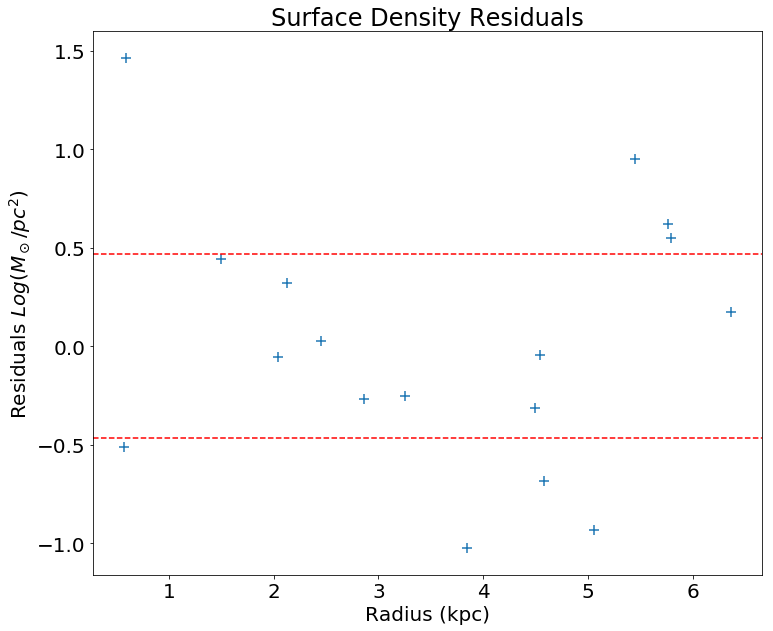

mad(Residual): 0.4657954862602378


In [56]:
'''
model is sigma = A*exp(B*r)
A central density 
B radial scale height 
r radius

ln(sigma) = lnA + B*r
'''

import statsmodels.api as sm 

fields = [bdor30,blmc1,blmc2,blmc3,blmc4,blmc5,blmc6,blmc7,blmc8,blmc9,blmc10,blmc11,blmc12,blmc13,blmc14,blmc16
          ,blmc17]
strfld = ["30Dor","LMC1","LMC2","LMC3","LMC4","LMC5","LMC6","LMC7","LMC8","LMC9","LMC10","LMC11","LMC12","LMC13",
          "LMC14","LMC16","LMC17"]
masses = [mass30dor,masslmc1,masslmc2,masslmc3,masslmc4,masslmc5,masslmc6,masslmc7,masslmc8,masslmc9,masslmc10,
          masslmc11,masslmc12,masslmc13,masslmc14,masslmc16,masslmc17]

radii = []
angles = []
surfden = []
for i in range(len(fields)):
    radii.append(np.sqrt(np.median(LMCdisk_cart(r13bloop_cut['RA'][fields[i]],
                                                r13bloop_cut['DEC'][fields[i]])[0])**2+
                         np.median(LMCdisk_cart(r13bloop_cut['RA'][fields[i]],
                                                r13bloop_cut['DEC'][fields[i]])[1])**2))
    
    surfden.append((masses[i]/fa.apogee_field_area(strfld[i],r13bloop_cut)))
    angles.append(np.arctan2(np.median(LMCdisk_cart(r13bloop_cut['RA'][fields[i]],
                                                    r13bloop_cut['DEC'][fields[i]])[1])
                             ,np.median(LMCdisk_cart(r13bloop_cut['RA'][fields[i]],
                                                    r13bloop_cut['DEC'][fields[i]])[0])))

# colangles = np.degrees(angles - (np.pi/2)*np.ones(len(angles)))+310
# for j in range(len(colangles)):
#     if colangles[j]<0:
#         colangles[i] = colangles[i]+360

model = np.array([radii]).T
model = sm.add_constant(model)
model_model = sm.RLM(np.log(np.divide(surfden,10**6)),model).fit()
model_predictions = model_model.predict(model)
model_residual = model_predictions - np.log(np.divide(surfden,10**6))
model_summary = model_model.summary()
print(model_summary)
print(np.asarray(model_model.params))
plt.figure(figsize=[12,10])
plt.scatter(radii,model_residual,marker='+',label='Residuals',cmap='nipy_spectral',s=100)
plt.axhline(mad(model_residual),linestyle='--',c='r',label='MAD')
plt.axhline(-mad(model_residual),linestyle='--',c='r')
plt.title(r'Surface Density Residuals')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Residuals $Log(M_\odot/pc^2)$')
# plt.colorbar()
plt.savefig('residexpmodel.pdf',bbox_inches='tight')
plt.show()
print('mad(Residual):',mad(model_residual))

In [57]:
surfden

dense = []
for i in range(len(clndr16)):
    if clndr16['FIELD'][i] == '30Dor':
        dense.append(surfden[0])
    if clndr16['FIELD'][i] == 'LMC1':
        dense.append(surfden[1])
    if clndr16['FIELD'][i] == 'LMC2':
        dense.append(surfden[2])
    if clndr16['FIELD'][i] == 'LMC3':
        dense.append(surfden[3])
    if clndr16['FIELD'][i] == 'LMC4':
        dense.append(surfden[4])
    if clndr16['FIELD'][i] == 'LMC5':
        dense.append(surfden[5])
    if clndr16['FIELD'][i] == 'LMC6':
        dense.append(surfden[6])
    if clndr16['FIELD'][i] == 'LMC7':
        dense.append(surfden[7])
    if clndr16['FIELD'][i] == 'LMC8':
        dense.append(surfden[8])
    if clndr16['FIELD'][i] == 'LMC9':
        dense.append(surfden[9])
    if clndr16['FIELD'][i] == 'LMC10':
        dense.append(surfden[10])
    if clndr16['FIELD'][i] == 'LMC11':
        dense.append(surfden[11])
    if clndr16['FIELD'][i] == 'LMC12':
        dense.append(surfden[12])
    if clndr16['FIELD'][i] == 'LMC13':
        dense.append(surfden[13])
    if clndr16['FIELD'][i] == 'LMC14':
        dense.append(surfden[14])
#     if clndr16['FIELD'][i] == 'LMC15':
#         masses.append(surfden[15])
    if clndr16['FIELD'][i] == 'LMC16':
        dense.append(surfden[15])
    if clndr16['FIELD'][i] == 'LMC17':
        dense.append(surfden[16])
        
# print(dense)
# print(np.divide(dense,10**6))


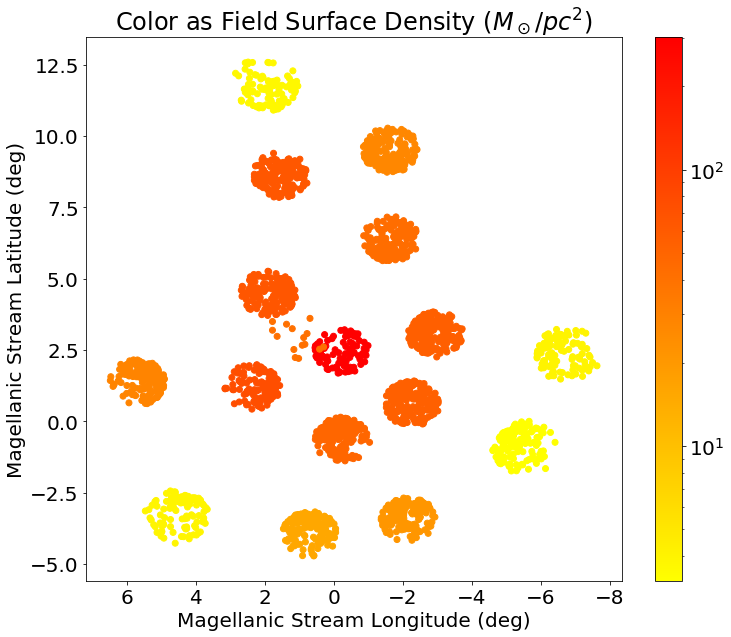

In [59]:
plt.figure(figsize=[12,10])
plt.scatter(ms_lg-360,ms_bg,c=np.divide(dense,10**6),cmap='autumn_r',norm=matplotlib.colors.LogNorm())
plt.gca().invert_xaxis()
plt.title(r'Color as Field Surface Density ($M_\odot/pc^2$)')
plt.colorbar()
plt.xlabel(r'Magellanic Stream Longitude (deg)')
plt.ylabel(r'Magellanic Stream Latitude (deg)')
plt.savefig('densemap.pdf',bbox_inches='tight')
plt.show()

In [60]:
print(np.divide(surfden,10**6))
print(surfden)

[ 41.43450354   3.25656054   3.9788358   21.15065237  56.08789271
  54.24824347  43.17814843  27.37310293  49.48316895 301.55311382
  15.5593496   64.49014348   3.73142249  64.92906363  75.86486119
   3.92840797  28.88368776]
[41434503.536715716, 3256560.5387448347, 3978835.800773727, 21150652.366789334, 56087892.70564128, 54248243.46550037, 43178148.4331839, 27373102.933443554, 49483168.95056994, 301553113.81764084, 15559349.603881579, 64490143.47681929, 3731422.493565585, 64929063.62734091, 75864861.19243512, 3928407.9655434056, 28883687.76365054]


In [61]:
##############################
### Define Density Profile ###
##############################

def lndenprof(r):
    p = [5.5563,-0.6282661] #[19.3718,-0.6283] #[ 19.2302, -0.5964] #[ 5.41466412, -0.59643876]
    return p[0]+np.multiply(p[1],r)

In [133]:
np.exp(5.5563)
np.reciprocal(0.6282661)

1.5916822505623014

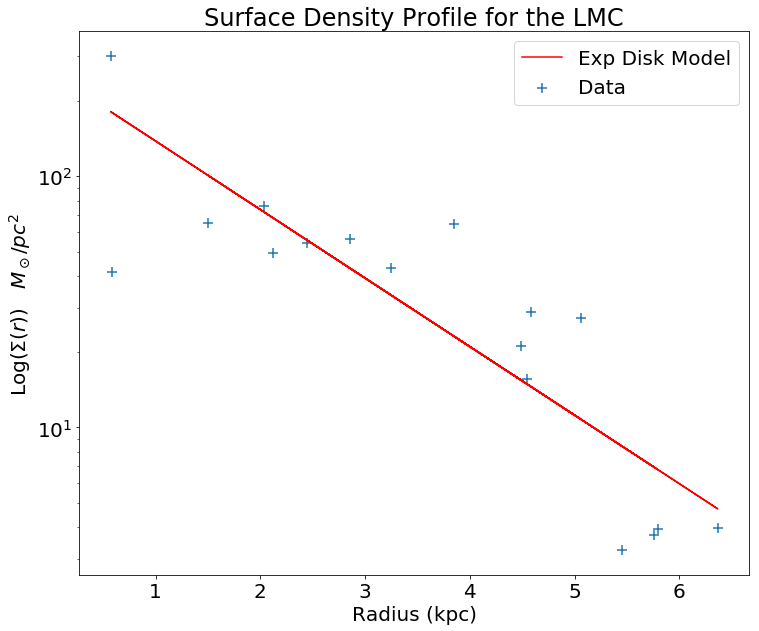

In [62]:
#######################################
### Overall Surface density Profile ###
#######################################

# color = np.degrees(angles)+90 

plt.figure(figsize=[12,10])
plt.scatter(radii,np.divide(surfden,10**6),marker='+',label='Data',cmap='nipy_spectral',s=100)
plt.plot(radii,np.exp(lndenprof(radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$')
plt.title('Surface Density Profile for the LMC')
plt.legend()
# plt.colorbar()
plt.savefig('overalldensity.pdf',bbox_inches='tight')
plt.show()

In [47]:
###############
### Fe Bins ### 
###############

bcorabsH = absmag(r13bloop_cut['H'],stardist[bloop_cut])-r13bloop_cut['AK_TARG']

fields = [bdor30,blmc1,blmc2,blmc3,blmc4,blmc5,blmc6,blmc7,blmc8,blmc9,blmc10,blmc11,blmc12,blmc13,blmc14,blmc16
          ,blmc17]
strfld = ["30Dor","LMC1","LMC2","LMC3","LMC4","LMC5","LMC6","LMC7","LMC8","LMC9","LMC10","LMC11","LMC12","LMC13",
          "LMC14","LMC16","LMC17"]

#single fields
sfields = [bdor30,blmc4,blmc5,blmc6,blmc8,blmc9,blmc13,blmc14]
sstrfld = ["30Dor","LMC3","LMC4","LMC5","LMC6","LMC8","LMC9","LMC13","LMC14"]

#double fields
dfields = [blmc1,blmc2,blmc7,blmc10,blmc11,blmc12,blmc16,blmc17]
dstrfield = ["LMC1","LMC2","LMC7","LMC10","LMC11","LMC12","LMC16","LMC17"]

#bins
fehbin1 = np.where(r13bloop_cut['FE_H']>-0.5)
fehbin2 = np.where((r13bloop_cut['FE_H']<=-0.5)&(r13bloop_cut['FE_H']>-1.0))
fehbin3 = np.where((r13bloop_cut['FE_H']<=-1.0)&(r13bloop_cut['FE_H']>-1.5))
fehbin4 = np.where(r13bloop_cut['FE_H']<=-1.5)


## FEHBIN1

In [ ]:
f1dor30 = np.where(clndr16['FIELD'][fehbin1]=='30Dor')
f1lmc1 = np.where(clndr16['FIELD'][fehbin1]=='LMC1')
f1lmc2 = np.where(clndr16['FIELD'][fehbin1]=='LMC2')
f1lmc3 = np.where(clndr16['FIELD'][fehbin1]=='LMC3')
f1lmc4 = np.where(clndr16['FIELD'][fehbin1]=='LMC4')
f1lmc5 = np.where(clndr16['FIELD'][fehbin1]=='LMC5')
f1lmc6 = np.where(clndr16['FIELD'][fehbin1]=='LMC6')
f1lmc7 = np.where(clndr16['FIELD'][fehbin1]=='LMC7')
f1lmc8 = np.where(clndr16['FIELD'][fehbin1]=='LMC8')
f1lmc9 = np.where(clndr16['FIELD'][fehbin1]=='LMC9')
f1lmc10 = np.where(clndr16['FIELD'][fehbin1]=='LMC10')
f1lmc11 = np.where(clndr16['FIELD'][fehbin1]=='LMC11')
f1lmc12 = np.where(clndr16['FIELD'][fehbin1]=='LMC12')
f1lmc13 = np.where(clndr16['FIELD'][fehbin1]=='LMC13')
f1lmc14 = np.where(clndr16['FIELD'][fehbin1]=='LMC14')
f1lmc16 = np.where(clndr16['FIELD'][fehbin1]=='LMC16')
f1lmc17 = np.where(clndr16['FIELD'][fehbin1]=='LMC17')

In [49]:
#30 Dor
mass30dor=fm.apogee_field_mass(8.7,-0.65,max(corabsH[dor30]),min(corabsH[dor30]),clndr16[dor30]['SELECTFUNC'][0],
                    len(np.squeeze(f1dor30)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 4
masslmc4=fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc4]),min(corabsH[lmc4]),clndr16[lmc4]['SELECTFUNC'][0],
                    len(np.squeeze(f1lmc4)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 5
masslmc5=fm.apogee_field_mass(8.7,-0.66,max(corabsH[lmc5]),min(corabsH[lmc5]),clndr16[lmc5]['SELECTFUNC'][0],
                    len(np.squeeze(f1lmc5)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 6
masslmc6=fm.apogee_field_mass(8.7,-0.67,max(corabsH[lmc6]),min(corabsH[lmc6]),clndr16[lmc6]['SELECTFUNC'][0],
                    len(np.squeeze(f1lmc6)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 8
masslmc8=fm.apogee_field_mass(8.7,-0.63,max(corabsH[lmc8]),min(corabsH[lmc8]),clndr16[lmc8]['SELECTFUNC'][0],
                    len(np.squeeze(f1lmc8)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 9
masslmc9=fm.apogee_field_mass(8.7,-0.63,max(corabsH[lmc9]),min(corabsH[lmc9]),clndr16[lmc9]['SELECTFUNC'][0],
                    len(np.squeeze(f1lmc9)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 13
masslmc13=fm.apogee_field_mass(8.7,-0.63,max(corabsH[lmc13]),min(corabsH[lmc13]),clndr16[lmc13]['SELECTFUNC'][0],
                    len(np.squeeze(f1lmc13)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
#LMC 14
masslmc14=fm.apogee_field_mass(8.7,-0.66,max(corabsH[lmc14]),min(corabsH[lmc14]),clndr16[lmc14]['SELECTFUNC'][0],
                    len(np.squeeze(f1lmc14)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')

########################################################
### Mass of Fields with composite Bright/Faint stars ###
########################################################

fnt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='FntRGB')
fnt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='FntRGB')
fnt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='FntRGB')
fnt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='FntRGB')
fnt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='FntRGB')
fnt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='FntRGB')
fnt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='FntRGB')
fnt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='FntRGB')
fnt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='FntRGB')

brt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='BrtRGB')
brt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='BrtRGB')
brt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='BrtRGB')
brt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='BrtRGB')
brt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='BrtRGB')
brt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='BrtRGB')
brt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='BrtRGB')
brt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='BrtRGB')
brt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='BrtRGB')

#LMC 1
fntlmc1 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc1][fnt1]),min(corabsH[lmc1][fnt1]),
                             clndr16[lmc1][fnt1]['SELECTFUNC'][0],len(np.squeeze(fnt1)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc1 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc1][brt1]),min(corabsH[lmc1][brt1]),
                             clndr16[lmc1][brt1]['SELECTFUNC'][0],len(np.squeeze(brt1)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc1 = fntlmc1+brtlmc1

#LMC 2
fntlmc2 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc2][fnt2]),min(corabsH[lmc2][fnt2]),
                             clndr16[lmc2][fnt2]['SELECTFUNC'][0],len(np.squeeze(fnt2)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc2 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc2][brt2]),min(corabsH[lmc2][brt2]),
                             clndr16[lmc2][brt2]['SELECTFUNC'][0],len(np.squeeze(brt2)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc2 = fntlmc2+brtlmc2

#LMC 3
fntlmc3 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc3][fnt3]),min(corabsH[lmc3][fnt3]),
                             clndr16[lmc3][fnt3]['SELECTFUNC'][0],len(np.squeeze(fnt3)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc3 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc3][brt3]),min(corabsH[lmc3][brt3]),
                             clndr16[lmc3][brt3]['SELECTFUNC'][0],len(np.squeeze(brt3)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc3 = fntlmc3+brtlmc3

#LMC 7
fntlmc7 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc7][fnt7]),min(corabsH[lmc7][fnt7]),
                             clndr16[lmc7][fnt7]['SELECTFUNC'][0],len(np.squeeze(fnt7)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc7 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc7][brt7]),min(corabsH[lmc7][brt7]),
                             clndr16[lmc7][brt7]['SELECTFUNC'][0],len(np.squeeze(brt7)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc7 = fntlmc7+brtlmc7

#LMC 10
fntlmc10 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc10][fnt10]),min(corabsH[lmc10][fnt10]),
                             clndr16[lmc10][fnt10]['SELECTFUNC'][0],len(np.squeeze(fnt10)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc10 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc10][brt10]),min(corabsH[lmc10][brt10]),
                             clndr16[lmc10][brt10]['SELECTFUNC'][0],len(np.squeeze(brt10)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc10 = fntlmc10+brtlmc10

#LMC 11
fntlmc11 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc11][fnt11]),min(corabsH[lmc11][fnt11]),
                             clndr16[lmc11][fnt11]['SELECTFUNC'][0],len(np.squeeze(fnt11)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc11 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc11][brt11]),min(corabsH[lmc11][brt11]),
                             clndr16[lmc11][brt11]['SELECTFUNC'][0],len(np.squeeze(brt11)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc11 = fntlmc11+brtlmc11

#LMC 12
fntlmc12 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc12][fnt12]),min(corabsH[lmc12][fnt12]),
                             clndr16[lmc12][fnt12]['SELECTFUNC'][0],len(np.squeeze(fnt12)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc12 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc12][brt12]),min(corabsH[lmc12][brt12]),
                             clndr16[lmc12][brt12]['SELECTFUNC'][0],len(np.squeeze(brt12)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc12 = fntlmc12+brtlmc12

#LMC 16
fntlmc16 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc16][fnt16]),min(corabsH[lmc16][fnt16]),
                             clndr16[lmc16][fnt16]['SELECTFUNC'][0],len(np.squeeze(fnt16)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc16 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc16][brt16]),min(corabsH[lmc16][brt16]),
                             clndr16[lmc16][brt16]['SELECTFUNC'][0],len(np.squeeze(brt16)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc16 = fntlmc16+brtlmc16

#LMC 17
fntlmc17 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc17][fnt17]),min(corabsH[lmc17][fnt17]),
                             clndr16[lmc17][fnt17]['SELECTFUNC'][0],len(np.squeeze(fnt17)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
brtlmc17 = fm.apogee_field_mass(8.7,-0.64,max(corabsH[lmc17][brt17]),min(corabsH[lmc17][brt17]),
                             clndr16[lmc17][brt17]['SELECTFUNC'][0],len(np.squeeze(brt17)),
                             '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')
masslmc17 = fntlmc17+brtlmc17

8

-4.494479420928801
-4.494479420928801
-4.494479420928801
-4.494479420928801
-4.494479420928801
-4.494479420928801
-4.494479420928801
-4.494479420928801


In [51]:
len(corabsH[fehbin1])

107

In [52]:
1/0.59643876

1.6766180655328304

In [112]:
np.sum(np.divide(masses,10**9))

0.9092529132595607